# Импорт библиотек

In [48]:
import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from PIL import Image
import torchvision.transforms as tfs
import torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import LabelEncoder

In [4]:
train_dir = Path("/kaggle/input/journey-springfield/train/simpsons_dataset")
test_dir = Path("/kaggle/input/journey-springfield/testset/testset")

train_files = list(train_dir.rglob('*.jpg'))
test_files = list(test_dir.rglob('*.jpg'))

train_labels = [path.parent.name for path in train_files]

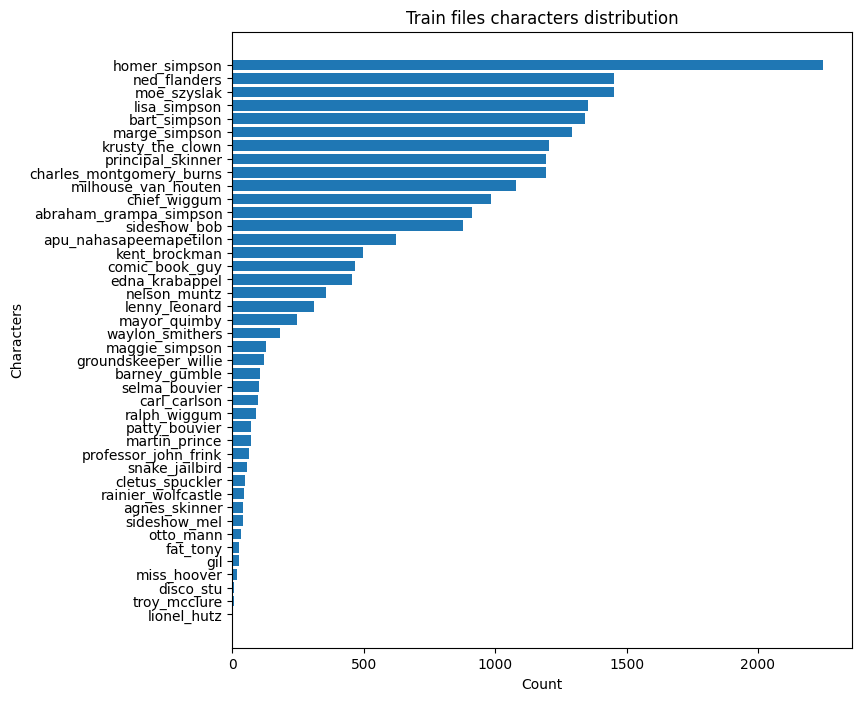

In [5]:
# Распределение классов

counts = pd.Series(train_labels).value_counts()

plt.figure(figsize=(8,8))
plt.barh(counts.keys()[::-1], counts.sort_values(ascending=True))
plt.title('Train files characters distribution')
plt.xlabel('Count')
plt.ylabel('Characters')
plt.show();

Классы распределены неравномерно, применим аугментацию для увеличения количества изображений

In [6]:
modes = ['train', 'test']

class Simpsons(Dataset):
    def __init__(self, files, mode):
        self.files = files
        self.mode = mode
        self.len_ = len(self.files)
        
        if self.mode not in modes:
            raise ValueError(f'{self.mode} incorrect. Use actual in {modes}.')
            
        self.label_encoder = LabelEncoder()
        
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('le.pickle', 'wb') as dumped_file:
                pickle.dump(self.label_encoder, dumped_file)

        self.transform_test = tfs.Compose([
            tfs.Resize(size=(224,224), antialias=True),
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        self.augmentation = tfs.RandomChoice([
            tfs.Compose([
                tfs.Resize(size=300, max_size=301),
                tfs.CenterCrop(size=300),
                tfs.RandomCrop(250),
                tfs.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                tfs.RandomPerspective(distortion_scale=0.5, p=0.5),
                tfs.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                tfs.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.33))
            ]),
            tfs.RandomRotation(degrees=(-25,25)),
            tfs.RandomHorizontalFlip(p=1)
        ])
        
        self.transform_train = tfs.Compose([
            self.augmentation,
            tfs.Resize(size=(224,224), antialias=True),
            tfs.ToTensor(),
            tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return self.len_
    
    def load_img(self, file):
        img = Image.open(file)
        img.load()
        return img
    
    def __getitem__(self, idx):
        file = self.files[idx]
        x = self.load_img(file)
        
        if self.mode == 'test':
            x = self.transform_test(x)
            return x
        else:
            x = self.transform_train(x)
            label = self.labels[idx]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [7]:
train_dataset = Simpsons(train_files, mode='train')
test_dataset = Simpsons(test_files, mode='test')

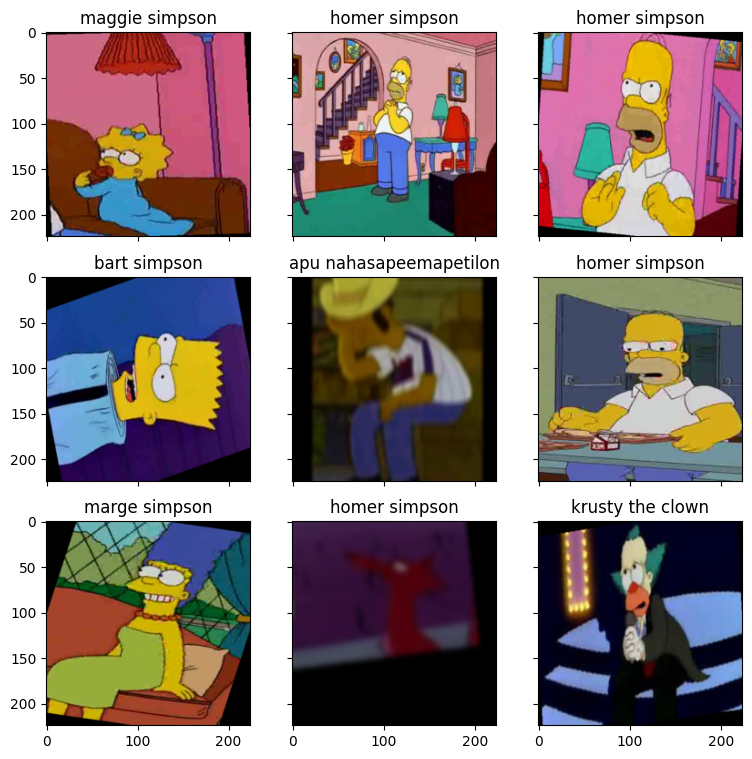

In [8]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
fig, ax = plt.subplots(figsize=(9,9), sharey=True, sharex=True,
                       nrows=3, ncols=3)

for figx in ax.ravel():
    random_character = np.array(np.random.uniform(20000), dtype='int').item()
    img, label = train_dataset[random_character]
    img = img.permute(1,2,0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    figx.set_title(" ".join(train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    figx.imshow(img)

# Аугментация данных

In [9]:
count_weights = {k: 1/v for k,v in counts.items()}
sample_weights = len(train_files) * [0]

for i, (data, label) in enumerate(tqdm(train_dataset)):
    label_weight = count_weights[train_dataset.label_encoder.inverse_transform([label])[0]]
    sample_weights[i] = label_weight

100%|██████████| 20933/20933 [05:22<00:00, 64.82it/s]


In [10]:
N = counts.max() * len(count_weights)

In [11]:
train_sampler = WeightedRandomSampler(sample_weights, num_samples=int(N), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# Обучение

In [41]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla P100-PCIE-16GB


In [42]:
class SimpleCNN(nn.Module):
    
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=2400, out_features=4800),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=4800),
            nn.ReLU(),
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4800, out_features=42)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [43]:
classes = len(np.unique(train_dataset.labels))
model = SimpleCNN(classes)
model = model.to(DEVICE)

In [44]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0
    running_corrects = 0
    running_data = 0
    
    for inputs, label in tqdm_notebook(train_loader):
        inputs = inputs.to(DEVICE)
        label = label.to(DEVICE)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * label.size(0)
        preds = outputs.argmax(-1)
        running_corrects += (preds == label).sum()
        running_data += label.size(0)
    
    scheduler.step()
    train_acc = running_corrects / running_data
    train_loss = running_loss / running_data
    
    return train_loss, train_acc

In [45]:
def train(model, epochs, batch_size, train_loader):
    
    history = []
    
    log_template = 'Epoch - {ep: 03d}, train loss: {tr_loss: 0.4f}, train acc: {tr_acc: 0.4f}'
    
    with tqdm(desc='Epoch', total=epochs) as pbar:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            history.append((train_loss, train_acc))
            pbar.update(1)
            tqdm.write(log_template.format(ep=epoch+1, tr_loss=train_loss, tr_acc=train_acc))
            
    return history

In [46]:
def predict(model, test_loader):
    
    logits = []
    
    with torch.no_grad():
        for data in tqdm(test_loader):
            data = data.to(DEVICE)
            model.eval()
            outputs = model(data)
            logits.append(outputs)
            
    return logits

In [49]:
epochs = 20
batch_size = 128
history = train(model, epochs, batch_size, train_loader)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_36/3963472197.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, label in tqdm_notebook(train_loader):


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:   5%|▌         | 1/20 [07:13<2:17:17, 433.54s/it]

Epoch -  01, train loss:  2.0658, train acc:  0.4518


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  10%|█         | 2/20 [14:21<2:09:03, 430.19s/it]

Epoch -  02, train loss:  1.0081, train acc:  0.7328


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  15%|█▌        | 3/20 [21:27<2:01:21, 428.35s/it]

Epoch -  03, train loss:  0.7813, train acc:  0.7916


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  20%|██        | 4/20 [28:29<1:53:34, 425.91s/it]

Epoch -  04, train loss:  0.6561, train acc:  0.8242


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  25%|██▌       | 5/20 [35:31<1:46:04, 424.33s/it]

Epoch -  05, train loss:  0.6035, train acc:  0.8396


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  30%|███       | 6/20 [42:21<1:37:53, 419.56s/it]

Epoch -  06, train loss:  0.4783, train acc:  0.8742


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  35%|███▌      | 7/20 [49:17<1:30:38, 418.34s/it]

Epoch -  07, train loss:  0.4524, train acc:  0.8798


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  40%|████      | 8/20 [56:19<1:23:55, 419.60s/it]

Epoch -  08, train loss:  0.4286, train acc:  0.8877


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  45%|████▌     | 9/20 [1:03:18<1:16:54, 419.49s/it]

Epoch -  09, train loss:  0.4207, train acc:  0.8892


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  50%|█████     | 10/20 [1:10:09<1:09:27, 416.73s/it]

Epoch -  10, train loss:  0.4059, train acc:  0.8932


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  55%|█████▌    | 11/20 [1:16:59<1:02:10, 414.54s/it]

Epoch -  11, train loss:  0.4005, train acc:  0.8953


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  60%|██████    | 12/20 [1:23:46<55:00, 412.52s/it]  

Epoch -  12, train loss:  0.3999, train acc:  0.8951


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  65%|██████▌   | 13/20 [1:30:42<48:14, 413.56s/it]

Epoch -  13, train loss:  0.3956, train acc:  0.8970


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  70%|███████   | 14/20 [1:37:56<41:57, 419.61s/it]

Epoch -  14, train loss:  0.3937, train acc:  0.8963


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  75%|███████▌  | 15/20 [1:45:04<35:10, 422.12s/it]

Epoch -  15, train loss:  0.3927, train acc:  0.8976


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  80%|████████  | 16/20 [1:52:04<28:05, 421.42s/it]

Epoch -  16, train loss:  0.3939, train acc:  0.8969


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  85%|████████▌ | 17/20 [1:58:54<20:54, 418.19s/it]

Epoch -  17, train loss:  0.3949, train acc:  0.8977


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  90%|█████████ | 18/20 [2:05:55<13:57, 418.84s/it]

Epoch -  18, train loss:  0.3954, train acc:  0.8977


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch:  95%|█████████▌| 19/20 [2:12:47<06:56, 416.89s/it]

Epoch -  19, train loss:  0.3919, train acc:  0.8973


  0%|          | 0/737 [00:00<?, ?it/s]

Epoch: 100%|██████████| 20/20 [2:19:32<00:00, 418.64s/it]

Epoch -  20, train loss:  0.3951, train acc:  0.8963


In [51]:
predictions = predict(model, test_loader)

100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


In [52]:
preds = nn.functional.softmax(torch.cat(predictions), dim=-1).argmax(-1).cpu().numpy()

In [54]:
predictions = train_dataset.label_encoder.inverse_transform(preds)
id_lab = [path.name for path in test_files]

In [55]:
pd.DataFrame({'Id': id_lab, 'Expected': predictions}).to_csv('preds.csv', index=False)

После загрузки предиктов на платформе получил скор - 0.98087

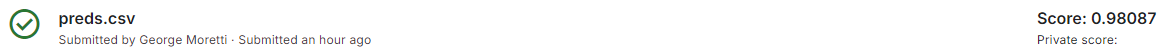